# Can we represent spectral lines with dense tensors in PyTorch?

April 26, 2021  
gully

How large of an array can we make?

In [1]:
import torch

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 100,000 lines, after which time my laptop runs out of RAM.  I have not tried to do this experiment on the GPU yet.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [2]:
N_lines = 100_000 # Can go up to 100_000 until it 

We will adopt units of "deciAngstrom", equal to one tenth of an Angstrom.  This choice will help us stick to using integers, which is needed for the sparse index approach.

In [3]:
lam_lo = 105000
lam_hi = 110000
Delta_lam = lam_hi - lam_lo

In [4]:
wingcut = 100

In [5]:
lam_vec = torch.arange(lam_lo-wingcut, lam_hi+wingcut, step=1)
n_pix = len(lam_vec)

In [6]:
n_pix

5200

Draw $N_{lines}$ random wavelength centers $\lambda_c$, amplitudes $A$, and widths $w$ to simulate authentic spectral lines.

In [7]:
lam_centers_native = lam_lo + Delta_lam*torch.rand(N_lines)
amplitudes = 0.01 + 0.3*torch.rand(N_lines)
widths = 4.1*torch.ones_like(amplitudes)

Stack the patches into a tensor and offset them by the line center position.

In [8]:
del_lambda_rv = -10.123456789 # Demo

The truncated indices are fixed, and will not update based on the RV.  This allows the RV to be inferred with back-propagation.

In [9]:
lam_centers_native.shape

torch.Size([100000])

In [10]:
lambda_patches_native = lam_vec.unsqueeze(1) - lam_centers_native + del_lambda_rv

In [11]:
lam_vec.shape, lambda_patches_native.shape

(torch.Size([5200]), torch.Size([5200, 100000]))

In [12]:
absorption_per_line = amplitudes*torch.exp(-0.5*lambda_patches_native**2/widths**2)

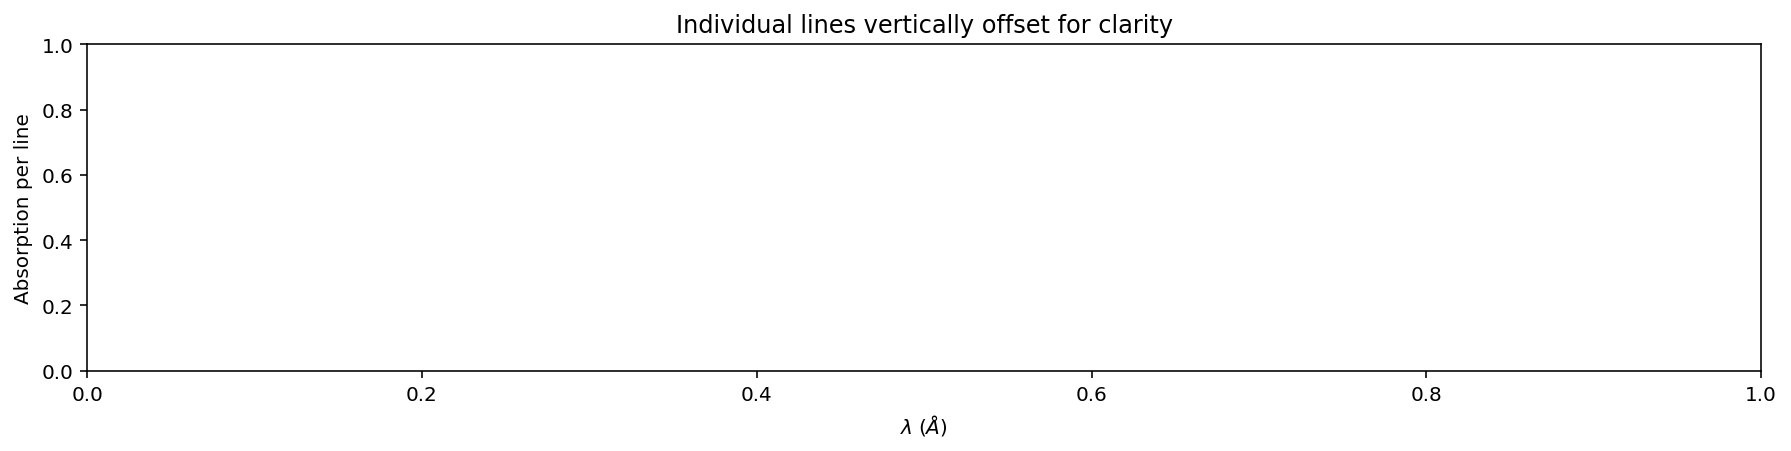

In [13]:
plt.figure(figsize=(15, 3))
#plt.plot(lam_vec/10, 1-absorption_per_line);
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Absorption per line')
plt.title('Individual lines vertically offset for clarity');

The lines sum together to make the net spectrum. To sum the spectrum we need to make a sparse tensor!

In [14]:
summed_vec = absorption_per_line.sum(dim=1)

In [15]:
lam_vec.shape, summed_vec.shape

(torch.Size([5200]), torch.Size([5200]))

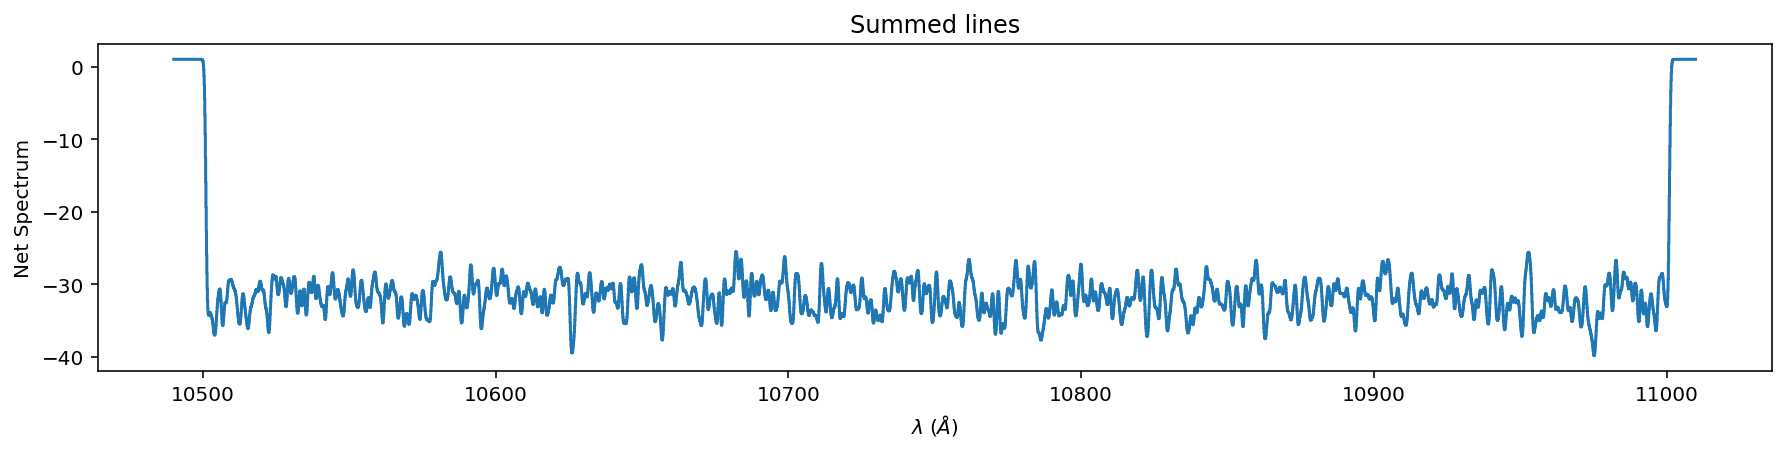

In [16]:
plt.figure(figsize=(15, 3))
plt.step(lam_vec/10, 1- summed_vec);
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Net Spectrum')
plt.title('Summed lines');

## Put it all together

Let's define a model that takes in RV, width, and optionally amplitudes.

In [17]:
def model_spectrum(rv, width, amplitudes):
    '''Generate the model spectrum given an RV and width  
    
    parameters
    ----------
    rv: (torch float)
        The radial velocity expressed as a wavelength shift, i.e. deciAngstroms.
    width: (torch float)
        The linewidth in units of deciAngstroms.
    amplitudes: (torch tensor)
        The vector of N_lines amplitudes for the strength of each line.
    '''
    lambda_patches_native = lam_vec.unsqueeze(1) - lam_centers_native + del_lambda_rv
    absorption_per_line = amplitudes*torch.exp(-0.5*lambda_patches_native**2/width**2)
    
    return absorption_per_line.sum(1)

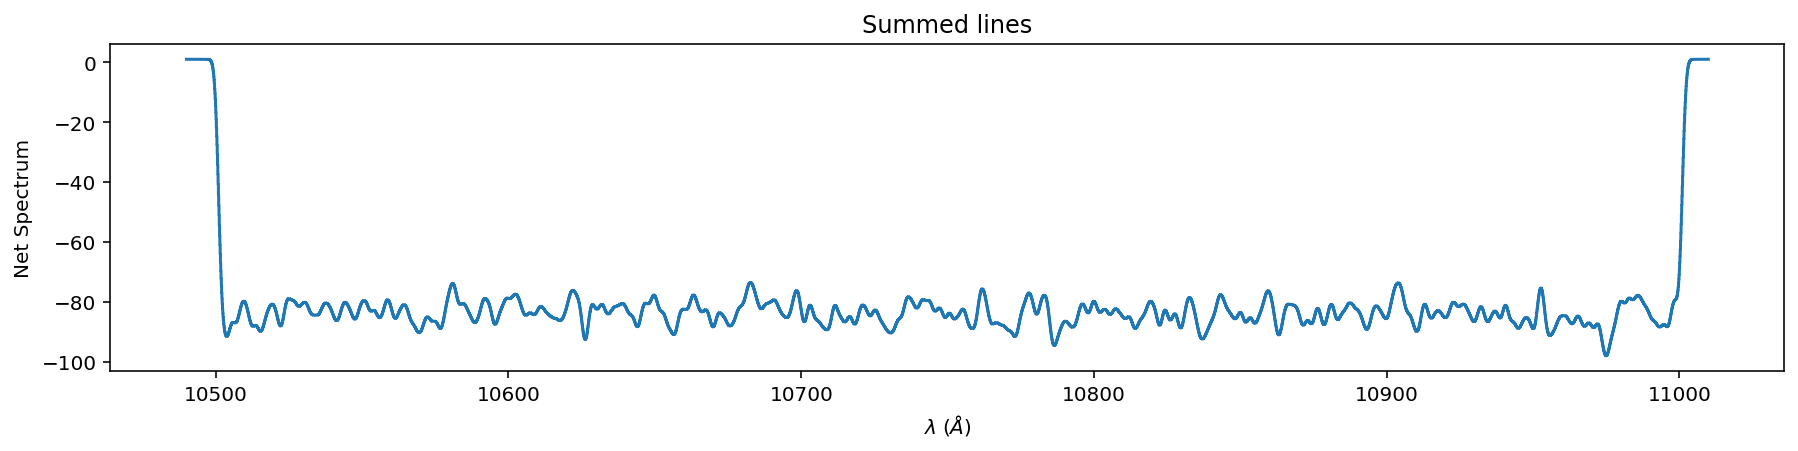

In [18]:
plt.figure(figsize=(15, 3))
plt.step(lam_vec/10, 1- model_spectrum(10.4, 10.6, amplitudes));
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Net Spectrum')
plt.title('Summed lines');

In [19]:
%%time 
model_spectrum(-30.1, 2.3, amplitudes)

CPU times: user 10.9 s, sys: 4.45 s, total: 15.3 s
Wall time: 2.87 s


tensor([0., 0., 0.,  ..., 0., 0., 0.])